# Import thư viện

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Hàm cov, corr, mse

In [2]:
def mse(x, y):
    summation = 0
    n = len(y)
    for i in range(0, n):
        difference = y[i] - x[i]
        squared_difference = difference ** 2
        summation = summation + squared_difference
    return summation / n

#ham tuong quan
def covariance(x,y):
    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))
    
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    
    numerator = sum([sub_x[i] * sub_y[i] for i in range(len(sub_x))])
    denominator = len(x) - 1
    cov = numerator / denominator
    return cov

#ham phuong sai
def correlation(x, y):
    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))

    sub_x = [i - mean_x for i in x]

    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i] * sub_y[i] for i in range(len(sub_x))])

    std_deviation_x = sum([sub_x[i] ** 2.0 for i in range(len(sub_x))])
    std_deviation_y = sum([sub_y[i] ** 2.0 for i in range(len(sub_y))])

    denominator = (std_deviation_x * std_deviation_y) ** 0.5
    cor = numerator / denominator
    return cor


# Load dataset

In [3]:
#Load dữ liệu
df = pd.read_csv('dataset.csv')

df.columns = df.columns.str.strip()
X = pd.DataFrame(np.c_[df['age'], df['sex'], df['cp'], df['trestbps'], df['chol'], df['fbs'], df['restecg'], df['thalach'], df['exang'], df['oldpeak'], df['slope'], df['ca'], df['thal']], columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal'])
X = df[['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].values
y = df['target'].values


In [4]:
#In ra các features
col_names = list(df.columns)
col_names.remove('target')
col_names

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [5]:
#Tính cov, corr của các features so với target
cov = [covariance(df[name], df['target']) for name in col_names]
corr = [correlation(df[name], df['target']) for name in col_names]

corr_df = pd.DataFrame([col_names, cov, corr]).T
corr_df.columns = ['col', 'cov', 'corr']
corr_df

,col,cov,corr
0,age,-0.933732,-0.1925
1,sex,-0.059651,-0.256453
2,cp,-0.184409,-0.390689
3,trestbps,-1.167041,-0.123362
4,chol,-1.679262,-0.078769
5,fbs,0.005398,0.030526
6,restecg,-0.08668,-0.174844
7,thalach,4.780613,0.400367
8,exang,-0.086294,-0.368824
9,oldpeak,-0.210316,-0.379669


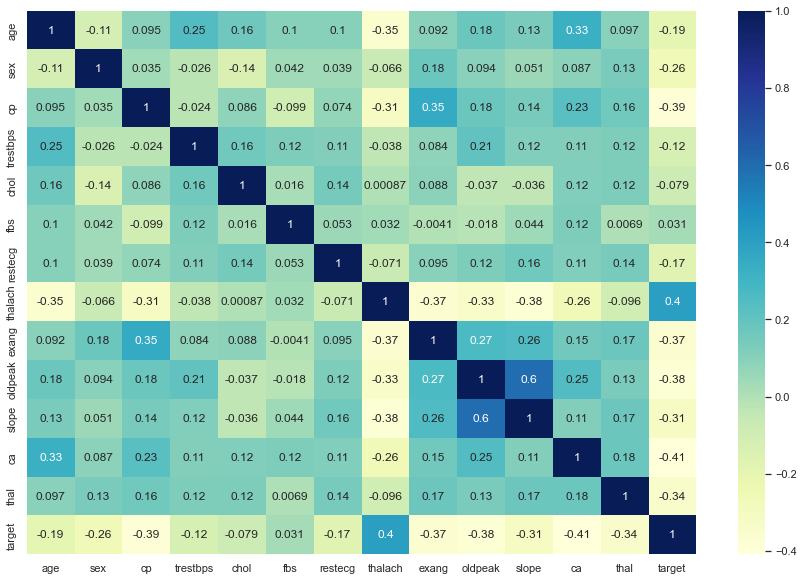

In [6]:
#Bảng corr
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df.iloc[:,0:14].corr(), annot=True, cmap="YlGnBu")
plt.show()

# Hàm train_test_split

In [19]:
#Hàm chia tập dữ liệu
import random

def random_split_data(X, y, split_ratio = 0.8):

        #lấy kích thước
        m, n =X.shape

        #random
        random_idx = list(range(m))
        random.shuffle(random_idx)

        #chia
        threshold = int(m*split_ratio)

        train_idx = random_idx[:threshold]
        test_idx = random_idx[threshold:]

        X_train = X[train_idx,:]
        y_train = y[train_idx]
        X_test = X[test_idx,:]
        y_test = y[test_idx]

        return X_train, y_train, X_test, y_test

In [20]:
X_train, y_train, X_test, y_test = random_split_data(X,y)
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

Kích thước tập train: (16848, 13)
Kích thước tập test: (4212, 13)


# Hàm Decision Tree

In [21]:
class Node:
    '''
    thực hiện một nút cây duy nhất.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value
        
# Lớp node lưu chữ dữ liệu về feature, threshold, dataleft, dataright, infomation gain và giá trị nút lá
# Tất cả ban đầu được đặt thành none
# The root(nút gốc) và decision nodes(nút quyết định) chứa gtri cho mọi thứ 
# the leaf node value(gtri nút lá), the leaf node(nút lá) chứa gtrị ngược lại

In [22]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        '''
        hàm tạo, giữ các giá trị cho min_samples_split và max_deep
        Đây là những siêu tham số. Cái đầu tiên được sử dụng để chỉ định số lượng mẫu tối thiểu cần thiết để tách một nút và cái 
        thứ hai chỉ định độ sâu tối đa của cây
        '''
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Hàm trợ giúp, tính toán entropy từ một mảng các giá trị số nguyên.
        tính toán tạp chất của một vector đầu vào s
        
        :tham số s: list
        :return: float, entropy value
        '''
        # Convert to integers để tránh lỗi thời gian chạy
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Xác xuất mỗi nhãn lớp
        percentages = counts / len(s)

        # Tính entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Hàm trợ giúp, tính toán mức tăng thông tin từ parent node và two child node.
        tính toán giá trị infomartion_gain của sự phân chia giữa parent và two child
        
        :tham số parent: list, the parent node
        :tham số left_child: list, left child of a parent
        :tham số right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Tính toán mức phân chia tốt nhất cho các feature và target nhất định
        tính toán các tham số phân tách tốt nhất cho các tính năng đầu vào X và một biến mục tiêu y. Nó làm như vậy bằng cách 
        lặp qua mọi cột trong Xvà mọi giá trị ngưỡng trong mỗi cột để tìm ra sự phân chia tối ưu bằng cách sử dụng thông 
        tin thu được
        
        :tham số X: np.array, features
        :tham số y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # Đối với mọi feature trong dataset
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # Đối với mọi giá trị duy nhất của feature đó
            for threshold in np.unique(X_curr):
                # Xây dựng tập dữ liệu và chia nó thành các phần bên trái và bên phải
                # Phần bên trái bao gồm các records lower hoặc bằng ngưỡng
                # Phần bên phải bao gồm các records higher so với ngưỡng
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Chỉ thực hiện phép tính nếu có dữ liệu trong cả hai tập hợp con
                if len(df_left) > 0 and len(df_right) > 0:
                    # Lấy giá trị của biến mục tiêu cho các tập hợp con
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Tính information gain và lưu các tham số chia
                    # lấy split tốt nhất
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Hàm đệ quy trợ giúp, dùng để xây dựng cây quyết định từ dữ liệu đầu vào.
        chức năng xây dựng đệ quy cây quyết định cho đến khi đáp ứng tiêu chí dừng (siêu tham số trong hàm tạo)
        
        :tham số X: np.array, features
        :tham số y: np.array or list, target
        :tham số depth: độ sâu hiện tại của cây, được sử dụng làm tiêu chí dừng
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Kiểm tra xem một nút có phải là leaf node không
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # Nếu sự phân chia không thuần túy
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - giá trị là giá trị mục tiêu phổ biến nhất
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        sử dụng để huấn luyện mô hình .
        hàm gọi _build() và lưu trữ cây đã xây dựng cho hàm tạo
        
        :tham số X: np.array, features
        :tham số y: np.array or list, target
        :return: None
        '''
        # Gọi một hàm đệ quy để xây dựng cây
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        sử dụng để dự đoán một trường hợp duy nhất (duyệt cây).
        chức năng đi qua cây để phân loại một trường hợp duy nhất
        
        :tham số x: single observation
        :tham số tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        chức năng áp dụng _predict()chức năng cho mọi trường hợp trong ma trận X
        
        :tham số X: np.array, features
        :return: np.array, predicted classes
        '''
        # Gọi hàm _predict() cho mọi quan sát
        return [self._predict(x, self.root) for x in X]

In [23]:
#Fit model
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Hàm accuracy_score


In [24]:
#Hàm tính độ chính xác
def compute_accuracy(y_test, preds):
    correctly_predicted = 0
    for true_label, predicted in zip(y_test, preds):
        if true_label == predicted:
            correctly_predicted += 1
    accuracy_score = correctly_predicted / len(y_test)
    return accuracy_score

In [25]:
#In ra độ chính xác mô hình
print(f"Độ chính xác của mô hình: ",compute_accuracy(y_test, preds))

Độ chính xác của mô hình:  0.8808167141500475


In [26]:
#Độ chính xác của mô hình
print(f"Train: ",compute_accuracy(y_train, model.predict(X_train)))

print(f"Test: ",compute_accuracy(y_test, model.predict(X_test)))

Train:  0.8722103513770181
Test:  0.8808167141500475


In [27]:
result = pd.DataFrame({"Dự đoán": preds, "Thực tế": y_test})
print(result)

      Dự đoán  Thực tế
0         1.0        1
1         0.0        0
2         1.0        1
3         0.0        0
4         1.0        1
...       ...      ...
4207      1.0        0
4208      1.0        1
4209      1.0        0
4210      1.0        1
4211      1.0        1

[4212 rows x 2 columns]


# Confusion_matrix

In [30]:
print(pd.crosstab(preds, y_test))

col_0     0     1
row_0            
0.0    1565   147
1.0     355  2145


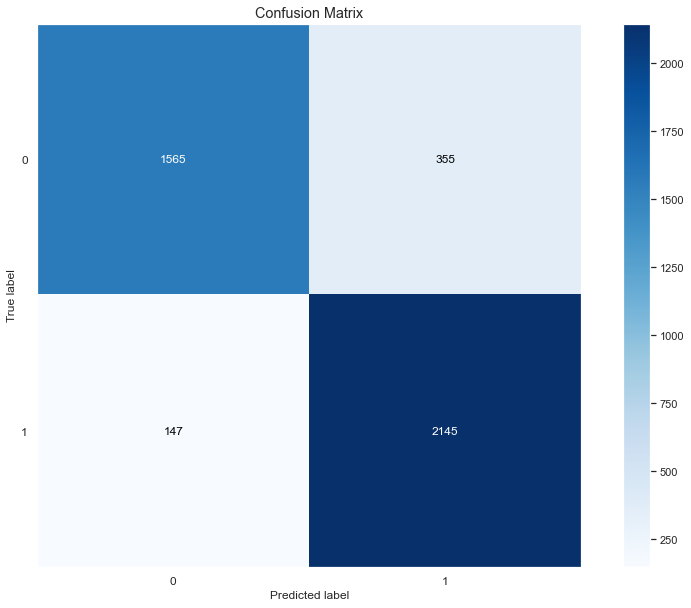

In [31]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test,preds,normalize=False)
plt.show()

#### TN: có 1565 số lượng dự đoán chính xác target là 0 
#### FN: có 355 số lượng dự đoán nhầm target là 0, thực tế phải là 1
#### FP: có 147 số lượng dự đoán nhầm target là 1, thực tế phải là 0
#### TP: có 2145 số lượng dự đoán chính xác target là 1